C:\Users\Airly\AppData\Local\Temp\ipykernel_28732\3163321167.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states_gdf["centroid"] = states_gdf.geometry.centroid
C:\Users\Airly\AppData\Local\Temp\ipykernel_28732\3163321167.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states_gdf["x"] = states_gdf.centroid.x
C:\Users\Airly\AppData\Local\Temp\ipykernel_28732\3163321167.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states_gdf["y"] = states_gdf.centroid.y


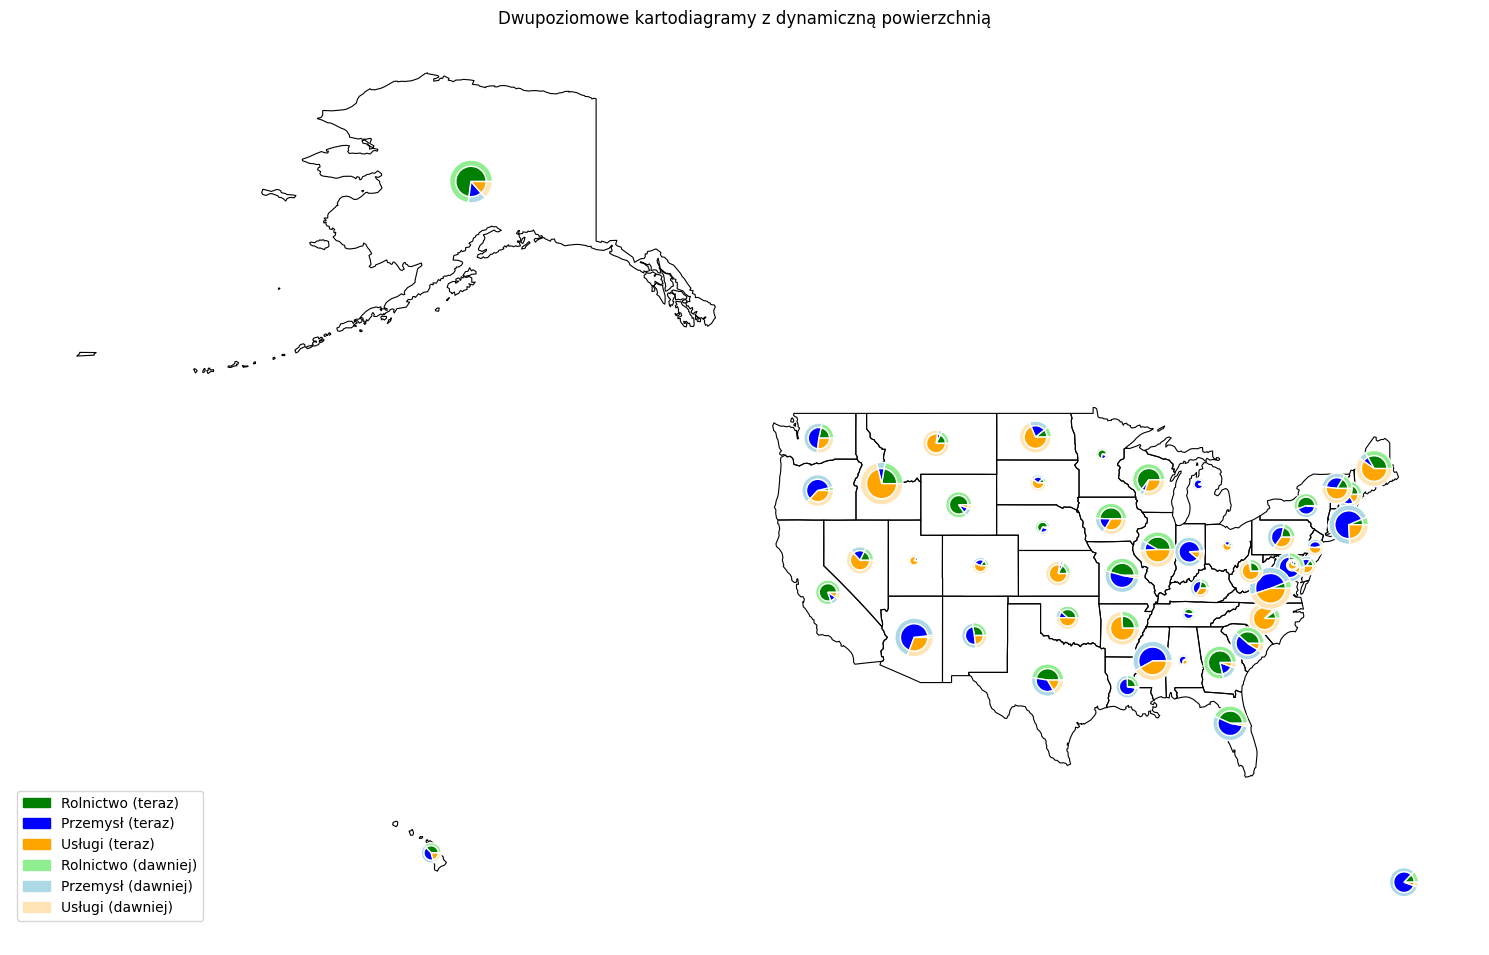

In [22]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Wczytanie danych granic stanów USA
states_gdf = gpd.read_file(r"d:\GIS\us-states.json")

# Losowanie danych strukturalnych i rozmiarów powierzchni
np.random.seed(42)
now = np.random.dirichlet(np.ones(3), size=len(states_gdf))
past = np.random.dirichlet(np.ones(3), size=len(states_gdf))
size = np.random.uniform(0.1, 0.4, size=len(states_gdf))  # Zwiększymy rozmiar powierzchni w mm²

# Dodanie do ramki danych
df = pd.DataFrame({
    "State": states_gdf["name"],
    "Agriculture": now[:, 0],
    "Industry": now[:, 1],
    "Services": now[:, 2],
    "Agriculture2": past[:, 0],
    "Industry2": past[:, 1],
    "Services2": past[:, 2],
    "size": size
})

states_gdf = states_gdf.set_index("name").join(df.set_index("State"))
states_gdf["centroid"] = states_gdf.geometry.centroid
states_gdf["x"] = states_gdf.centroid.x
states_gdf["y"] = states_gdf.centroid.y

# Rysowanie mapy z dynamicznie skalowanymi wykresami
fig, ax = plt.subplots(figsize=(15, 10))
states_gdf.geometry.boundary.plot(ax=ax, linewidth=0.8, color='black')

for _, row in states_gdf.iterrows():
    if pd.isna(row['Agriculture']) or pd.isna(row['Agriculture2']):
        continue

    inner = [row['Agriculture'], row['Industry'], row['Services']]
    outer = [row['Agriculture'], row['Industry'], row['Services']]
    x, y = row['x'], row['y']

    # Obliczenie promieni z powierzchni (A = π * r^2, więc r = sqrt(A / π))
    total_area = row['size']  # Powierzchnia całkowita
    radius_outer = np.sqrt(total_area / np.pi)  # Obliczamy promień zewnętrzny

    # Obliczamy powierzchnię pierścienia, zakładając, że ma to być różnica
    # powierzchni całkowitej i wewnętrznego koła
    ring_area = total_area / 2  # Załóżmy, że połowa powierzchni to pierścień
    radius_inner = np.sqrt(ring_area / np.pi)  # Obliczamy promień wewnętrzny

    # Zwiększamy rozmiar wykresu, aby były dwa razy większe
    size = radius_outer * 40.0  # Powiększamy o większy mnożnik

    pie_ax = ax.inset_axes([x - size / 2, y - size / 2, size, size], transform=ax.transData)

    # Outer ring (jako różnica między radius_outer a radius_inner)
    pie_ax.pie(outer, radius=radius_outer,
               colors=["lightgreen", "lightblue", "moccasin"],
               wedgeprops=dict(width=radius_outer - radius_inner, edgecolor='white'))

    # Inner pie
    pie_ax.pie(inner, radius=radius_inner,
               colors=["green", "blue", "orange"],
               wedgeprops=dict(width=radius_inner, edgecolor='white'))

    pie_ax.set_aspect('equal')
    pie_ax.axis('off')

# Legenda
patches = [
    mpatches.Patch(color='green', label='Rolnictwo (teraz)'),
    mpatches.Patch(color='blue', label='Przemysł (teraz)'),
    mpatches.Patch(color='orange', label='Usługi (teraz)'),
    mpatches.Patch(color='lightgreen', label='Rolnictwo (dawniej)'),
    mpatches.Patch(color='lightblue', label='Przemysł (dawniej)'),
    mpatches.Patch(color='moccasin', label='Usługi (dawniej)'),
]
ax.legend(handles=patches, loc='lower left')
ax.set_title("Dwupoziomowe kartodiagramy z dynamiczną powierzchnią")
ax.axis('off')
plt.tight_layout()
plt.show()
